In [34]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from scipy import stats
import glob
import os
from natsort import natsorted
plt.rcParams['figure.figsize'] = [10, 5]

In [35]:
path = 'viz_predictions/hug1'
im_num = '107'
img = cv2.imread(path+'/gray/'+im_num+'.jpg', 0)
img_rgb = cv2.imread(path+'/rgb/'+im_num+'.jpg', 1)
keypoints = np.load(path+'/keypoints/'+im_num+'.npy')

print('Shape of keypoints is {}'.format(keypoints.shape))
print('Array is of shape (No of hands, No of people, hand keypoints, 3)')
print('Final dimension is: y coordinate, x coordinate and confidence')
handloc = keypoints[:,:,:,0:2].astype(int)

Shape of keypoints is (2, 2, 21, 3)
Array is of shape (No of hands, No of people, hand keypoints, 3)
Final dimension is: y coordinate, x coordinate and confidence


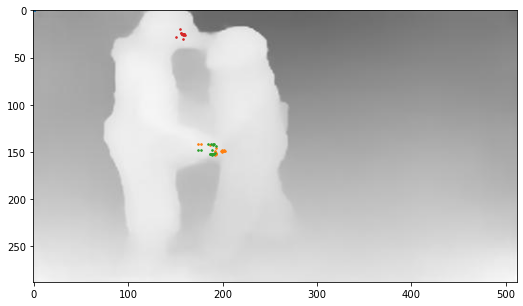

In [36]:
plt.imshow(cv2.cvtColor(img,cv2.COLOR_BGR2RGB))
num_ppl = handloc.shape[1]

for pers in range(0,num_ppl):
    plt.scatter(handloc[0][pers][:,0], handloc[0][pers][:,1], s=2.5)
    plt.scatter(handloc[1][pers][:,0], handloc[1][pers][:,1], s=2.5)
    
# hands3D = handloc
# plt.savefig('test.jpg')

In [37]:
#Extracting depth values of each hand named as 'person_number__left/right'
hands3D = np.zeros(keypoints.shape)

for pers in range(num_ppl):
    for hand in range(hands3D.shape[0]):
        depth = img[handloc[hand,pers,:,1], handloc[hand,pers,:,0]] 
        hands3D[hand,pers,:,2] = depth
    hands3D[:,pers,:,0:2] = handloc[:,pers,:,:]
    hands3D = hands3D.astype(int)

# # THIS WAS FOR TWO PPL
# dep0_r = img[handloc[1,0,:,1], handloc[1,0,:,0]]
# dep0_l = img[handloc[0,0,:,1], handloc[0,0,:,0]]
# dep1_r = img[handloc[1,1,:,1], handloc[1,1,:,0]]
# dep1_l = img[handloc[0,1,:,1], handloc[0,1,:,0]]

# #3D hand positions
# pers0_left = np.vstack((handloc[0,0,:,1], handloc[0,0,:,0], dep0_l)).T.astype(int)
# pers0_right = np.vstack((handloc[1,0,:,1], handloc[1,0,:,0], dep0_r)).T.astype(int)
# pers1_left = np.vstack((handloc[0,1,:,1], handloc[0,1,:,0], dep1_l)).T.astype(int)
# pers1_right = np.vstack((handloc[1,1,:,1], handloc[1,1,:,0], dep1_r)).T.astype(int)

# hands3D = np.array([[pers0_left, pers1_left], [pers0_right, pers1_right]])

In [38]:
start_pt =[]
end_pt = []

for i in range(hands3D.shape[1]):
    for j in range(hands3D.shape[1]):
        if i != j:
            diff1 = abs(hands3D[0,i,:,:] - hands3D[0,j,:,:])
            eucdis1 = np.linalg.norm(diff1, axis=1)
            mode1, count1 = stats.mode(eucdis1)

            #Detect if Handshake and find min and max coordinates for bounding box and append to lisr
            if sum(eucdis1) < 180 and sum(eucdis1) != 0:
                print('Handshake1 detected. RUN!!!')
                xs1 = np.argmin(np.hstack((hands3D[0,i,:,1], hands3D[0,j,:,1])))
                ys1 = np.argmin(np.hstack((hands3D[0,i,:,0], hands3D[0,j,:,0])))
                xe1 = np.argmax(np.hstack((hands3D[0,i,:,1], hands3D[0,j,:,1])))
                ye1 = np.argmax(np.hstack((hands3D[0,i,:,0], hands3D[0,j,:,0])))
                start1 = (np.hstack((hands3D[0,i,:,0], hands3D[0,j,:,0]))[ys1], np.hstack((hands3D[0,i,:,1], hands3D[0,j,:,1]))[xs1])
                end1 = (np.hstack((hands3D[0,i,:,0], hands3D[0,j,:,0]))[ye1], np.hstack((hands3D[0,i,:,1], hands3D[0,j,:,1]))[xe1])
                start_pt.append(start1)
                end_pt.append(end1)

            diff2 = abs(hands3D[0,i,:,:] - hands3D[1,j,:,:])
            eucdis2 = np.linalg.norm(diff2, axis=1)
            mode2, count2 = stats.mode(eucdis2)

            #Detect if Handshake and find min and max coordinates for bounding box and append to lisr
            if sum(eucdis2) < 180 and sum(eucdis2) != 0:
                print('Handshake2 detected. RUN!!!')
                xs2 = np.argmin(np.hstack((hands3D[0,i,:,1], hands3D[1,j,:,1])))
                ys2 = np.argmin(np.hstack((hands3D[0,i,:,0], hands3D[1,j,:,0])))
                xe2 = np.argmax(np.hstack((hands3D[0,i,:,1], hands3D[1,j,:,1])))
                ye2 = np.argmax(np.hstack((hands3D[0,i,:,0], hands3D[1,j,:,0])))
                start2 = (np.hstack((hands3D[0,i,:,0], hands3D[1,j,:,0]))[ys2], np.hstack((hands3D[0,i,:,1], hands3D[1,j,:,1]))[xs2])
                end2 = (np.hstack((hands3D[0,i,:,0], hands3D[1,j,:,0]))[ye2], np.hstack((hands3D[0,i,:,1], hands3D[1,j,:,1]))[xe2])
                start_pt.append(start2)
                end_pt.append(end2)

            diff3 = abs(hands3D[1,i,:,:] - hands3D[0,j,:,:])
            eucdis3 = np.linalg.norm(diff3, axis=1)
            mode3, count3 = stats.mode(eucdis3)

            #Detect if Handshake and find min and max coordinates for bounding box and append to lisr
            if sum(eucdis3) < 180 and sum(eucdis3) != 0:
                print('Handshake3 detected. RUN!!!')
                xs3 = np.argmin(np.hstack((hands3D[1,i,:,1], hands3D[0,j,:,1])))
                ys3 = np.argmin(np.hstack((hands3D[1,i,:,0], hands3D[0,j,:,0])))
                xe3 = np.argmax(np.hstack((hands3D[1,i,:,1], hands3D[0,j,:,1])))
                ye3 = np.argmax(np.hstack((hands3D[1,i,:,0], hands3D[0,j,:,0])))
                start3 = (np.hstack((hands3D[1,i,:,0], hands3D[0,j,:,0]))[ys3], np.hstack((hands3D[1,i,:,1], hands3D[0,j,:,1]))[xs3])
                end3 = (np.hstack((hands3D[1,i,:,0], hands3D[0,j,:,0]))[ye3], np.hstack((hands3D[1,i,:,1], hands3D[0,j,:,1]))[xe3])
                start_pt.append(start3)
                end_pt.append(end3)

            diff4 = abs(hands3D[1,i,:,:] - hands3D[1,j,:,:])
            eucdis4 = np.linalg.norm(diff4, axis=1)
            mode4, count4 = stats.mode(eucdis4)

            #Detect if Handshake and find min and max coordinates for bounding box and append to lisr
            if sum(eucdis4) < 180 and sum(eucdis4) != 0:
                print('Handshake4 detected. RUN!!!')
                xs4 = np.argmin(np.hstack((hands3D[1,i,:,1], hands3D[1,j,:,1])))
                ys4 = np.argmin(np.hstack((hands3D[1,i,:,0], hands3D[1,j,:,0])))
                xe4 = np.argmax(np.hstack((hands3D[1,i,:,1], hands3D[1,j,:,1])))
                ye4 = np.argmax(np.hstack((hands3D[1,i,:,0], hands3D[1,j,:,0])))
                start4 = (np.hstack((hands3D[1,i,:,0], hands3D[1,j,:,0]))[ys4], np.hstack((hands3D[1,i,:,1], hands3D[1,j,:,1]))[xs4])
                end4 = (np.hstack((hands3D[1,i,:,0], hands3D[1,j,:,0]))[ye4], np.hstack((hands3D[1,i,:,1], hands3D[1,j,:,1]))[xe4])
                start_pt.append(start4)
                end_pt.append(end4)

#         mode = np.array([mode1,mode2,mode3,mode4])
num_cont = len(start_pt)
print("Number of handshakes = {}".format(num_cont/2))

print(start_pt, end_pt)

Number of handshakes = 0.0
[] []


(array([ 1.,  0.,  1.,  0.,  0.,  0.,  2.,  3., 11.,  3.]),
 array([115.47294055, 117.25268668, 119.03243281, 120.81217893,
        122.59192506, 124.37167118, 126.15141731, 127.93116344,
        129.71090956, 131.49065569, 133.27040182]),
 <BarContainer object of 10 artists>)

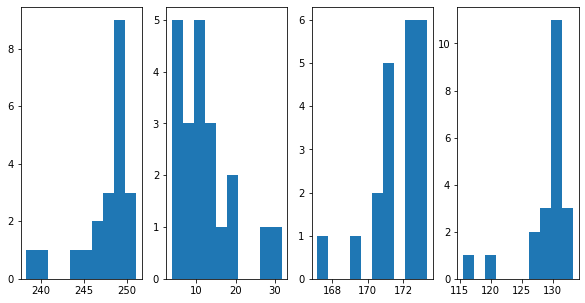

In [39]:
#Histogram of 2 norm for the 21 keypoints
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1,4)
ax1.hist(eucdis1)
ax2.hist(eucdis2)
ax3.hist(eucdis3)
ax4.hist(eucdis4)


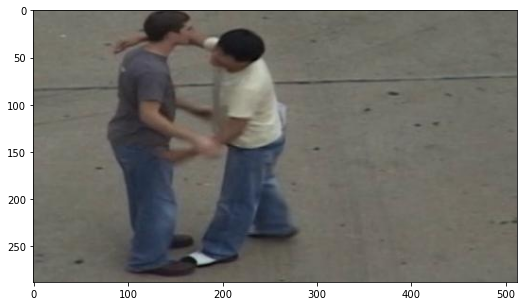

In [40]:
#Plot bounding box
for contact in range(len(start_pt)):
    cv2.rectangle(img_rgb, start_pt[contact], end_pt[contact],[0,0,255], 2)
plt.imshow(cv2.cvtColor(img_rgb,cv2.COLOR_BGR2RGB))
plt.show()

In [32]:
diff2 = abs(hands3D[0,1,:,:] - hands3D[1,2,:,:])
eucdis2 = np.linalg.norm(diff2, axis=1)
plt.hist(eucdis2)
sum(eucdis2)

IndexError: index 2 is out of bounds for axis 1 with size 2

In [247]:
from mpl_toolkits.mplot3d import Axes3D

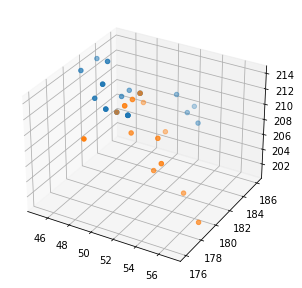

In [251]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

Axes3D.scatter(ax,hands3D[0,1,:,0], hands3D[0,1,:,1], hands3D[0,1,:,2], zdir='z')
Axes3D.scatter(ax,hands3D[1,2,:,0], hands3D[1,2,:,1], hands3D[1,2,:,2], zdir='z')


In [25]:
hands3D[0,1,:,:]

array([[193, 144, 233],
       [188, 142, 234],
       [185, 142, 237],
       [191, 142, 233],
       [189, 148, 231],
       [177, 148, 235],
       [190, 143, 233],
       [190, 142, 233],
       [192, 151, 224],
       [174, 148, 234],
       [190, 152, 222],
       [190, 152, 222],
       [191, 152, 221],
       [189, 152, 222],
       [189, 152, 222],
       [188, 152, 224],
       [187, 152, 226],
       [189, 152, 222],
       [189, 153, 220],
       [188, 152, 224],
       [187, 152, 226]])

In [27]:
hands3D[1,0,:,:]

array([[174, 141, 238],
       [177, 142, 239],
       [199, 149, 225],
       [201, 149, 223],
       [187, 143, 235],
       [202, 148, 222],
       [199, 150, 224],
       [192, 150, 226],
       [201, 149, 223],
       [203, 149, 221],
       [193, 151, 224],
       [192, 149, 228],
       [193, 146, 233],
       [202, 149, 222],
       [193, 152, 221],
       [193, 152, 221],
       [192, 152, 222],
       [199, 148, 227],
       [198, 149, 226],
       [191, 152, 221],
       [192, 153, 218]])